## CNN from Scratch for MNIST

- data:    `MNIST`
- model:   `CNN` {Convolution, Pooling}-blocks, Fully Connected Blocks
- metrics: `SGD`, `cross-entropy`

**Runtime** (5 epochs):
- `cpu` : 492.33 s = 8.2  min
- `gpu` : 13 s     = 0.25 min (32x improvement)

In [1]:
import os, time
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

import torch

import torchvision.datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchmetrics

In [2]:
# Hyperparameters
n_epochs = 500
b_size   = 512
l_rate   = 0.000001

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
def transformMNIST(img):
    '''
    Input PIL image -> tensor (C x H x W)
    '''
    f = transforms.PILToTensor()
    #g = transforms.Normalize(mean=4.0, std=1.0, inplace=True)
    
    out1 = f(img).type(torch.float)
    #out2 = g(out1)

    return out1

In [4]:
# data root
data_root = Path('/eagle/projects/candle_aesp/siebenschuh/PT/')

# load/pre-process data
dset_train = torchvision.datasets.MNIST(root=data_root, train=True, transform=transformMNIST, download=True)
dset_test  = torchvision.datasets.MNIST(root=data_root, train=False, transform=transformMNIST, download=True)

# dataloader
train_loader = DataLoader(dataset=dset_train, batch_size=b_size, shuffle=True, sampler=None, pin_memory=True, num_workers=4)
test_loader  = DataLoader(dataset=dset_test, batch_size=b_size, shuffle=True, sampler=None, pin_memory=True, num_workers=4)

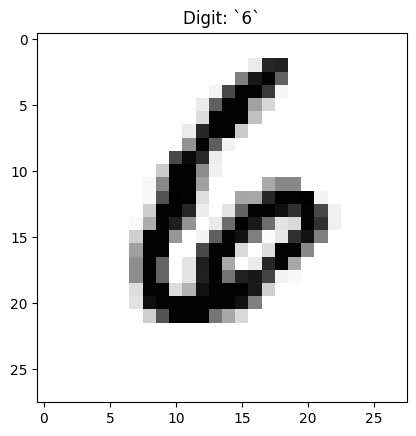

In [5]:
# Visualize (pre-processed) data
k_id = 13
plt.title(f'Digit: `{dset_train[k_id][1]}`')
plt.imshow(dset_train[k_id][0][0], cmap='Greys', vmin=0, vmax=255)
plt.show()

In [6]:
# model

class Net(nn.Module):
    def __init__(self, ):
        super().__init__()
        
        self.p_Dropout = 0.05
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=4)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.batch0 = nn.BatchNorm2d(num_features=1)
        self.batch1 = nn.BatchNorm2d(num_features=8)
        self.batch2 = nn.BatchNorm2d(num_features=32)
        
        self.flatten = nn.Flatten(start_dim=1)
        
        self.fc1     = nn.Linear(in_features=800, out_features=128, bias=True)
        self.fc2     = nn.Linear(in_features=128, out_features=64,  bias=True)
        self.fc3     = nn.Linear(in_features=64,  out_features=32,  bias=True)
        self.fc4     = nn.Linear(in_features=32,  out_features=10,  bias=True)
        
        self.dropout1 = nn.Dropout(p=self.p_Dropout)
        self.dropout2 = nn.Dropout(p=self.p_Dropout)
        self.dropout3 = nn.Dropout(p=self.p_Dropout)
    
    def forward(self, x):
        x = self.batch0(x)
        x = self.conv1(x)
        x = F.relu(self.pool1(x))
        x = self.batch1(x)
        x = self.conv2(x)
        x = F.relu(self.pool2(x))
        x = self.batch2(x)
        
        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        
        return x
    
net = Net()

# -> device
net = net.to(device)

In [7]:
# Optimizer, criterion
optimizer = optim.Adam(params=net.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.08)
criterion = nn.CrossEntropyLoss()

In [8]:
# accuracy
acc = torchmetrics.Accuracy(task='multiclass', num_classes=10)

train_acc = []
test_acc  = []

# 
acc_local    = 0.0
running_loss = 0.0
loss_list    = []
t0 = time.time()

# 1st loop: epochs
for i in range(n_epochs):
    print(f'\nEpoch: {i}')
    
    # 2nd loop: train batches
    for j, batch in enumerate(train_loader):
        # unpack
        inputs, labels = batch
        
        # -> device 13s
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero grad
        optimizer.zero_grad()
        
        # backprop
        outputs = net(inputs)                  # forward
        loss    = criterion(outputs, labels)   # loss
        loss.backward()                        # backward 
        optimizer.step()
        
        # loss
        running_loss += loss.item()
        loss_list.append(loss.item())
        
        # print
        if(j%100==0):
            print(f'Loss : {loss:.2f}')
            
    # track
    train_acc.append(acc(outputs.argmax(dim=1).cpu(), labels.cpu()))
    
    
    # validation
    with torch.set_grad_enabled(False):
        test_acc_loc = []
        for batch in test_loader:
            inputs, labels = batch
            
            # -> device 13s
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # predict
            preds = net(inputs).argmax(dim=1)
    
            # accuracy
            test_acc_loc.append(acc(preds.cpu(), labels.cpu()))
        # append
        test_acc.append(np.mean(test_acc_loc))
            
t1 = time.time()

print('\nFinished\n')
print(f'Training Time : {t1-t0:.2f} for device={device.type}')


Epoch: 0
Loss : 2.31
Loss : 2.11

Epoch: 1
Loss : 2.06
Loss : 1.46

Epoch: 2
Loss : 1.38
Loss : 0.88

Epoch: 3
Loss : 0.83
Loss : 0.62

Epoch: 4
Loss : 0.52
Loss : 0.48

Epoch: 5
Loss : 0.47
Loss : 0.40

Epoch: 6
Loss : 0.40
Loss : 0.39

Epoch: 7
Loss : 0.33
Loss : 0.31

Epoch: 8
Loss : 0.35
Loss : 0.32

Epoch: 9
Loss : 0.30
Loss : 0.31

Epoch: 10
Loss : 0.29
Loss : 0.28

Epoch: 11
Loss : 0.26
Loss : 0.30

Epoch: 12
Loss : 0.29
Loss : 0.28

Epoch: 13
Loss : 0.32
Loss : 0.29

Epoch: 14
Loss : 0.28
Loss : 0.27

Epoch: 15
Loss : 0.31
Loss : 0.24

Epoch: 16
Loss : 0.26
Loss : 0.26

Epoch: 17
Loss : 0.26
Loss : 0.20

Epoch: 18
Loss : 0.26
Loss : 0.23

Epoch: 19
Loss : 0.28
Loss : 0.22

Epoch: 20
Loss : 0.24
Loss : 0.26

Epoch: 21
Loss : 0.21
Loss : 0.24

Epoch: 22
Loss : 0.25
Loss : 0.24

Epoch: 23
Loss : 0.25
Loss : 0.22

Epoch: 24
Loss : 0.25
Loss : 0.26

Epoch: 25
Loss : 0.23
Loss : 0.27

Epoch: 26
Loss : 0.23
Loss : 0.23

Epoch: 27
Loss : 0.25
Loss : 0.22

Epoch: 28
Loss : 0.22
Loss : 

Loss : 0.30

Epoch: 231
Loss : 0.26
Loss : 0.25

Epoch: 232
Loss : 0.27
Loss : 0.28

Epoch: 233
Loss : 0.27
Loss : 0.28

Epoch: 234
Loss : 0.31
Loss : 0.27

Epoch: 235
Loss : 0.26
Loss : 0.25

Epoch: 236
Loss : 0.27
Loss : 0.31

Epoch: 237
Loss : 0.33
Loss : 0.29

Epoch: 238
Loss : 0.28
Loss : 0.30

Epoch: 239
Loss : 0.31
Loss : 0.28

Epoch: 240
Loss : 0.27
Loss : 0.30

Epoch: 241
Loss : 0.27
Loss : 0.31

Epoch: 242
Loss : 0.26
Loss : 0.27

Epoch: 243
Loss : 0.28
Loss : 0.25

Epoch: 244
Loss : 0.27
Loss : 0.29

Epoch: 245
Loss : 0.25
Loss : 0.28

Epoch: 246
Loss : 0.28
Loss : 0.30

Epoch: 247
Loss : 0.27
Loss : 0.29

Epoch: 248
Loss : 0.32
Loss : 0.30

Epoch: 249
Loss : 0.26
Loss : 0.28

Epoch: 250
Loss : 0.28
Loss : 0.25

Epoch: 251
Loss : 0.27
Loss : 0.30

Epoch: 252
Loss : 0.29
Loss : 0.27

Epoch: 253
Loss : 0.29
Loss : 0.27

Epoch: 254
Loss : 0.28
Loss : 0.26

Epoch: 255
Loss : 0.25
Loss : 0.25

Epoch: 256
Loss : 0.26
Loss : 0.27

Epoch: 257
Loss : 0.26
Loss : 0.29

Epoch: 258
Loss

Loss : 0.31
Loss : 0.29

Epoch: 459
Loss : 0.28
Loss : 0.26

Epoch: 460
Loss : 0.27
Loss : 0.29

Epoch: 461
Loss : 0.26
Loss : 0.28

Epoch: 462
Loss : 0.29
Loss : 0.29

Epoch: 463
Loss : 0.29
Loss : 0.27

Epoch: 464
Loss : 0.27
Loss : 0.27

Epoch: 465
Loss : 0.28
Loss : 0.27

Epoch: 466
Loss : 0.29
Loss : 0.29

Epoch: 467
Loss : 0.29
Loss : 0.26

Epoch: 468
Loss : 0.27
Loss : 0.27

Epoch: 469
Loss : 0.30
Loss : 0.26

Epoch: 470
Loss : 0.28
Loss : 0.30

Epoch: 471
Loss : 0.26
Loss : 0.29

Epoch: 472
Loss : 0.29
Loss : 0.29

Epoch: 473
Loss : 0.28
Loss : 0.27

Epoch: 474
Loss : 0.27
Loss : 0.26

Epoch: 475
Loss : 0.26
Loss : 0.24

Epoch: 476
Loss : 0.26
Loss : 0.29

Epoch: 477
Loss : 0.26
Loss : 0.30

Epoch: 478
Loss : 0.27
Loss : 0.27

Epoch: 479
Loss : 0.26
Loss : 0.30

Epoch: 480
Loss : 0.26
Loss : 0.27

Epoch: 481
Loss : 0.24
Loss : 0.28

Epoch: 482
Loss : 0.31
Loss : 0.26

Epoch: 483
Loss : 0.25
Loss : 0.25

Epoch: 484
Loss : 0.26
Loss : 0.25

Epoch: 485
Loss : 0.29
Loss : 0.27

Epo

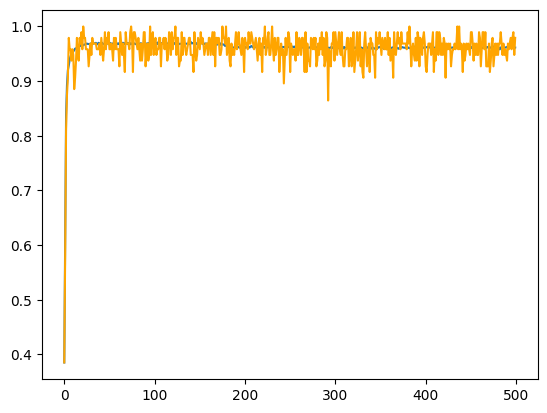

In [9]:
# visualize results
plt.plot(test_acc)
plt.plot(train_acc, color='orange')
plt.show()

In [10]:
# inference
acc_list = []
net.eval()

# store mislabeled images
mislabelded=[]

for batch in test_loader:
    # unpack
    inputs, labels = batch
    
    # -> device
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # predict
    preds = net(inputs)
    preds = preds.argmax(dim=1)
    
    # accuracy
    acc_list.append(acc(preds.cpu(), labels.cpu()))
    
print(f'Test accuracy: {100*np.mean(acc_list):.2f}%')

Test accuracy: 96.40%
